In [6]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

print("TensorFlow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)

TensorFlow version: 2.20.0
OpenCV version: 4.13.0


In [7]:
# Load Dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Normalization (Scale pixels to 0-1 range)
train_images, test_images = train_images / 255.0, test_images / 255.0

# Flatten data for Logistic Regression (Traditional ML requires 1D input)
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

print(f"Data Loaded: {len(train_images)} training images, {len(test_images)} test images.")

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\datasets\cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


Data Loaded: 50000 training images, 10000 test images.


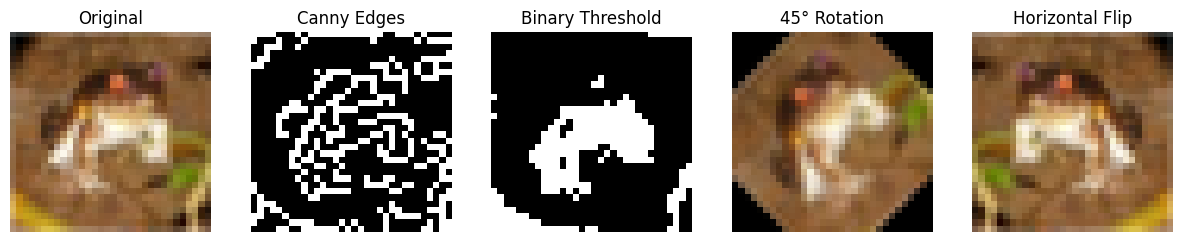

In [8]:
# Select a sample image (e.g., index 0 is a frog)
sample_idx = 0
sample_img = (train_images[sample_idx] * 255).astype(np.uint8)

# 1. Edge Detection (Canny)
gray = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray, 100, 200)

# 2. Thresholding
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# 3. Augmentation (Rotation & Flip)
(h, w) = sample_img.shape[:2]
M = cv2.getRotationMatrix2D((w//2, h//2), 45, 1.0)
rotated = cv2.warpAffine(sample_img, M, (w, h))
flipped = cv2.flip(sample_img, 1)

# Visualization
titles = ['Original', 'Canny Edges', 'Binary Threshold', '45° Rotation', 'Horizontal Flip']
imgs = [sample_img, edges, thresh, rotated, flipped]

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(imgs[i], cmap='gray' if i in [1, 2] else None)
    plt.title(titles[i])
    plt.axis('off')
plt.show()

In [9]:
print("Training Logistic Regression (Baseline)...")
# LogisticRegression automatically handles multinomial in newer sklearn versions
lr_model = LogisticRegression(max_iter=100, solver='lbfgs')
lr_model.fit(train_images_flat[:10000], train_labels[:10000].ravel())

lr_acc = lr_model.score(test_images_flat, test_labels)
print(f"Logistic Regression Test Accuracy: {lr_acc * 100:.2f}%")

Training Logistic Regression (Baseline)...
Logistic Regression Test Accuracy: 37.48%


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
print("Training CNN Model...")
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10)
])

cnn_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

# Train for 10 epochs
history = cnn_model.fit(train_images, train_labels, epochs=10, 
                        validation_data=(test_images, test_labels))

Training CNN Model...


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 20ms/step - accuracy: 0.4385 - loss: 1.5421 - val_accuracy: 0.5472 - val_loss: 1.2518
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.5781 - loss: 1.1855 - val_accuracy: 0.6113 - val_loss: 1.1122
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.6378 - loss: 1.0251 - val_accuracy: 0.6529 - val_loss: 0.9985
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.6792 - loss: 0.9181 - val_accuracy: 0.6826 - val_loss: 0.9116
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.7022 - loss: 0.8473 - val_accuracy: 0.6714 - val_loss: 0.9541
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.7232 - loss: 0.7947 - val_accuracy: 0.6876 - val_loss: 0.9121
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.7398 - loss: 0.7430 - val_accuracy: 0.7075 - val_loss: 0.8617
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.7525 -

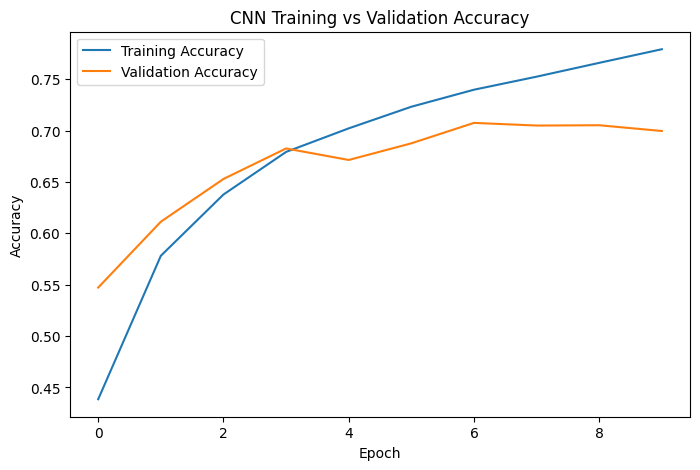

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


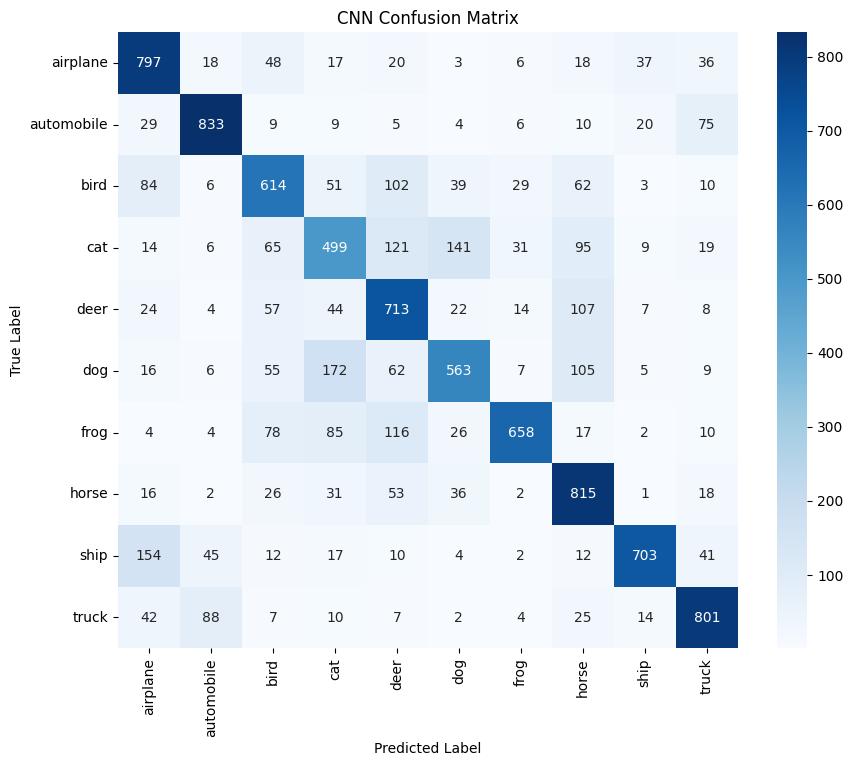

In [11]:
# 1. Accuracy Graph
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 2. Confusion Matrix
y_pred = np.argmax(cnn_model.predict(test_images), axis=1)
cm = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [12]:
print("--- PROJECT SUMMARY ---")
print(f"Logistic Regression Accuracy: {lr_acc*100:.2f}%")
print(f"CNN Final Validation Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")
print("\nConclusion: The CNN significantly outperforms Logistic Regression as it preserves spatial hierarchy in images.")

--- PROJECT SUMMARY ---
Logistic Regression Accuracy: 37.48%
CNN Final Validation Accuracy: 69.96%

Conclusion: The CNN significantly outperforms Logistic Regression as it preserves spatial hierarchy in images.
